### Importación de datos



In [ ]:
# ==============================================
# Análisis integral Alura Store
# ==============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from IPython.display import display, Markdown

url = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv"
url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv"
url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv"
url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv"

tienda = pd.read_csv(url)
tienda2 = pd.read_csv(url2)
tienda3 = pd.read_csv(url3)
tienda4 = pd.read_csv(url4)

tienda.head()

,Producto,Categoría del Producto,Precio,Costo de envío,Fecha de Compra,Vendedor,Lugar de Compra,Calificación,Método de pago,Cantidad de cuotas,lat,lon
0,Asistente virtual,Electrónicos,164300.0,6900.0,16/01/2021,Pedro Gomez,Bogotá,4,Tarjeta de crédito,8,4.60971,-74.08175
1,Mesa de comedor,Muebles,192300.0,8400.0,18/05/2022,Beatriz Morales,Medellín,1,Tarjeta de crédito,4,6.25184,-75.56359
2,Juego de mesa,Juguetes,209600.0,15900.0,15/03/2021,Juan Fernandez,Cartagena,1,Tarjeta de crédito,1,10.39972,-75.51444
3,Microondas,Electrodomésticos,757500.0,41000.0,03/05/2022,Juan Fernandez,Cali,4,Nequi,1,3.43722,-76.52250
4,Silla de oficina,Muebles,335200.0,20200.0,07/11/2020,Maria Alfonso,Medellín,5,Nequi,1,6.25184,-75.56359


## Recoger DataFrames de Tiendas

In [ ]:
def _colectar_tiendas():
    if 'tiendas' in globals() and 'nombres' in globals():
        assert len(tiendas) == len(nombres) and len(tiendas) > 0, "Listas 'tiendas' y 'nombres' deben tener el mismo tamaño."
        return tiendas, nombres

    pares = [('tienda','Tienda 1'), ('tienda2','Tienda 2'), ('tienda3','Tienda 3'), ('tienda4','Tienda 4')]
    tdfs, nms = [], []
    for var, nm in pares:
        df = globals().get(var)
        if isinstance(df, pd.DataFrame):
            tdfs.append(df)
            nms.append(nm)
    if not tdfs:
        raise ValueError("No encontré DataFrames de tiendas. Ejecuta antes la celda que los carga.")
    return tdfs, nms

tiendas_df, nombres_df = _colectar_tiendas()

## Normalización ligera (Variable global)

In [ ]:
def _col(df, preferido, aliases=()):
    cols = {c.lower(): c for c in df.columns}
    cand = [preferido] + list(aliases)
    for c in cand:
        if c and c.lower() in cols:
            return cols[c.lower()]
    for c_low, c_orig in cols.items():
        for c in cand:
            if c and c.lower() in c_low:
                return c_orig
    return None

def normalizar(df, nombre_tienda):
    precio = _col(df, 'Precio', ('price','valor','unit_price'))
    cat    = _col(df, 'Categoría del Producto', ('categoria','category','product_category'))
    calif  = _col(df, 'Calificación', ('review','rating','review_score','evaluación','evaluacion'))
    prod   = _col(df, 'Producto', ('product','nombre_producto'))
    envio  = _col(df, 'Costo de envío', ('shipping','freight_value','costo_envio','shipping_cost'))
    fecha  = _col(df, 'Fecha', ('order_purchase_timestamp','date','fecha_compra'))

    # parse de fecha con dayfirst para dd/mm/yyyy
    fecha_pars = pd.to_datetime(df[fecha], errors='coerce', dayfirst=True) if fecha else pd.NaT

    out = pd.DataFrame({
        'Tienda': nombre_tienda,
        'Producto': df[prod] if prod else np.nan,
        'Categoría': df[cat] if cat else np.nan,
        'Precio': pd.to_numeric(df[precio], errors='coerce') if precio else np.nan,
        'Costo de envío': pd.to_numeric(df[envio], errors='coerce') if envio else 0.0,
        'Calificación': pd.to_numeric(df[calif], errors='coerce') if calif else np.nan,
        'Fecha': fecha_pars
    })
    out['Costo de envío'] = out['Costo de envío'].fillna(0)
    return out

normalizadas = [normalizar(df, nm) for df, nm in zip(tiendas_df, nombres_df)]
all_df = pd.concat(normalizadas, ignore_index=True).dropna(subset=['Precio'])

## Métricas Base

In [ ]:
ingresos     = all_df.groupby('Tienda', as_index=False)['Precio'].sum().rename(columns={'Precio':'Ingresos'})
valoracion   = all_df.groupby('Tienda', as_index=False)['Calificación'].mean().rename(columns={'Calificación':'Valoración Prom.'})
envio_prom   = all_df.groupby('Tienda', as_index=False)['Costo de envío'].mean().rename(columns={'Costo de envío':'Envío Prom.'})
ventas_cat   = all_df.groupby(['Tienda','Categoría'], as_index=False).size().rename(columns={'size':'Unidades'})
ventas_prod  = all_df.groupby(['Tienda','Producto'],  as_index=False).size().rename(columns={'size':'Unidades'})

## Formatos

In [ ]:
def _formato_miles(x, pos):
    # miles con punto (LATAM): 1000000 -> 1.000.000
    s = f"{int(x):,}".replace(",", ".")
    return s

def _etiquetar_barras(ax, fmt=lambda v: f"{v:,.0f}".replace(',', '.')):
    for p in ax.patches:
        h = p.get_height()
        if np.isnan(h):
            continue
        ax.text(p.get_x() + p.get_width()/2, h,
                fmt(h), ha='center', va='bottom', fontsize=9, rotation=0)

#1. Análisis de facturación



In [ ]:

# Variable global
tiendas = [tienda, tienda2, tienda3, tienda4]
nombres = ['Tienda1', 'Tienda2', 'Tienda3', 'Tienda4']

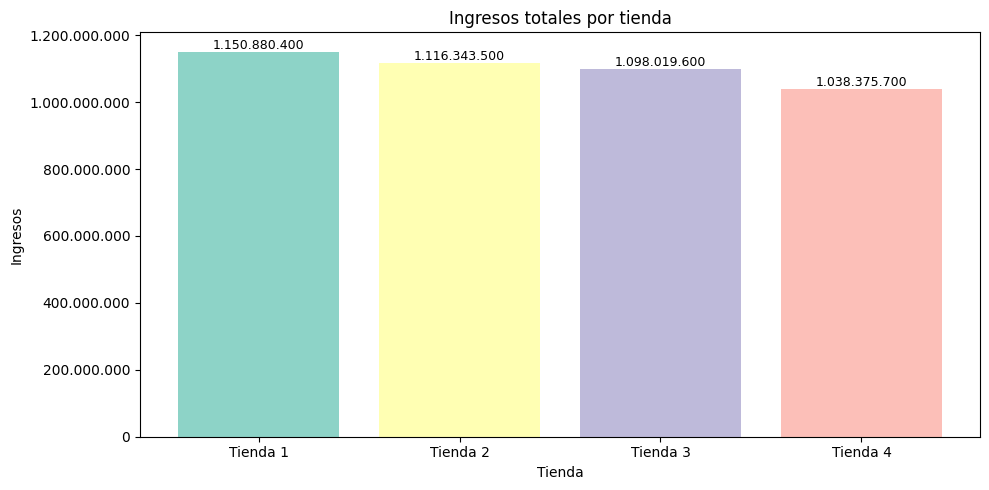

In [ ]:
def ingresosTiendas():
    plt.figure(figsize=(10,5))
    colores = mpl.colormaps['Set3']
    colors = [colores(i) for i in range(len(nombres_df))]
    orden = ingresos.sort_values('Ingresos', ascending=False)
    bars = plt.bar(orden['Tienda'], orden['Ingresos'],color=colors)
    # resaltar la peor (menor ingreso)
    peor = orden['Ingresos'].idxmin()
    bars[list(orden.index).index(peor)].set_alpha(0.5)

    plt.title('Ingresos totales por tienda')
    plt.xlabel('Tienda'); plt.ylabel('Ingresos')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(_formato_miles))
    _etiquetar_barras(plt.gca())
    plt.tight_layout(); plt.show()

ingresosTiendas()

### 1.1. Ingresos Mensuales por Tienda

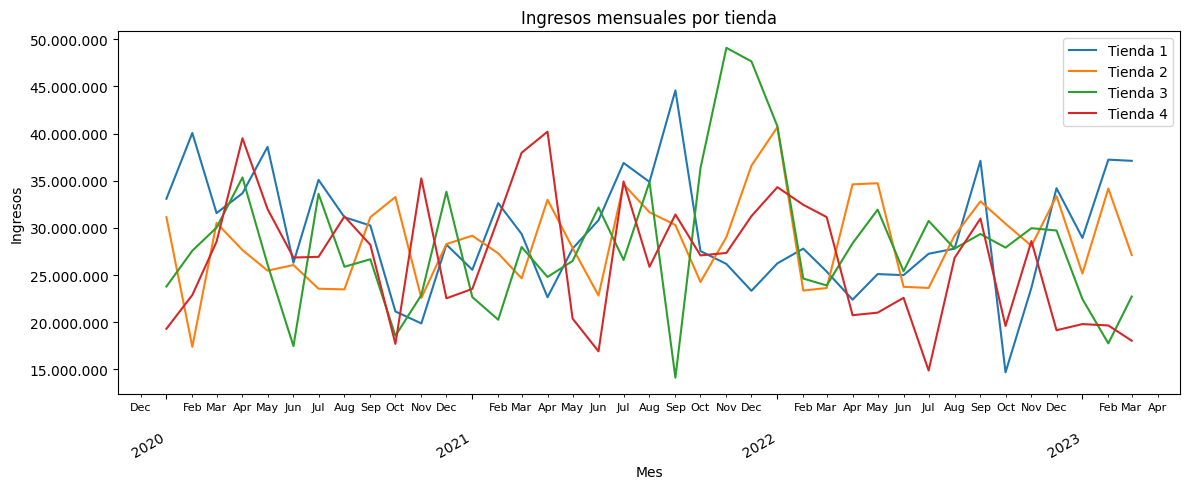

In [ ]:
def ingresos_mensuales_por_tienda():
  if all_df['Fecha'].notna().any():
    mensuales = (all_df.dropna(subset=['Fecha'])
                .assign(YearMonth=lambda d: d['Fecha'].dt.to_period('M').dt.to_timestamp())  # inicio de mes
                .groupby(['Tienda','YearMonth'], as_index=False)['Precio']
                .sum())
    pivot = (mensuales.pivot(index='YearMonth', columns='Tienda', values='Precio')
            .sort_index())

    full_idx = pd.date_range(pivot.index.min(), pivot.index.max(), freq='MS')
    pivot = pivot.reindex(full_idx, fill_value=0)
    pivot.index.name = 'YearMonth'

    fig, ax = plt.subplots(figsize=(12,5))
    for col in pivot.columns:
        ax.plot(pivot.index, pivot[col], label=col)

    ax.set_title('Ingresos mensuales por tienda')
    ax.set_xlabel('Mes'); ax.set_ylabel('Ingresos')
    ax.yaxis.set_major_formatter(FuncFormatter(_formato_miles))

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))     # año en línea aparte
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))       # Ene, Feb, ...

    ax.tick_params(axis='x', which='major', pad=12)
    ax.tick_params(axis='x', which='minor', labelsize=8, rotation=0)
    fig.autofmt_xdate()
    ax.legend()
    plt.tight_layout(); plt.show()

ingresos_mensuales_por_tienda()

# 2. Ventas por categoría

In [ ]:
def categorias_tiendas(tienda, nombre):
  categorias = {}
  for i in range(len(tienda)):
      categoria = tienda.loc[i, "Categoría del Producto"]

      if categoria in categorias:
          categorias[categoria] += 1
      else:
          categorias[categoria] = 1
  print(categorias)
  return graficos_tiendas(categorias, nombre)

In [ ]:
def graficos_tiendas(categorias,nombre):
  plt.figure(figsize=(10, 5))
  colores = mpl.colormaps['viridis']
  colors = [colores(i / len(nombres)) for i in range(len(nombres))]
  plt.bar(categorias.keys(), categorias.values(), color=colors)
  plt.xlabel("Categoría del Producto")
  plt.ylabel("Suma de Ventas")
  plt.title(f"Ventas por Categoría de {nombre}")
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

{'Electrónicos': 448, 'Muebles': 465, 'Juguetes': 324, 'Electrodomésticos': 312, 'Artículos para el hogar': 171, 'Deportes y diversión': 284, 'Libros': 173, 'Instrumentos musicales': 182}


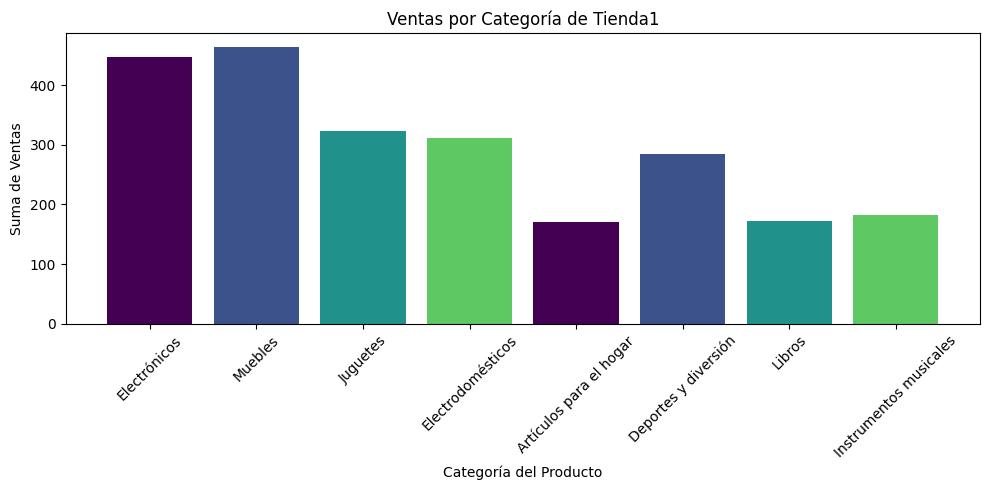

{'Muebles': 442, 'Instrumentos musicales': 224, 'Deportes y diversión': 275, 'Electrónicos': 422, 'Artículos para el hogar': 181, 'Juguetes': 313, 'Electrodomésticos': 305, 'Libros': 197}


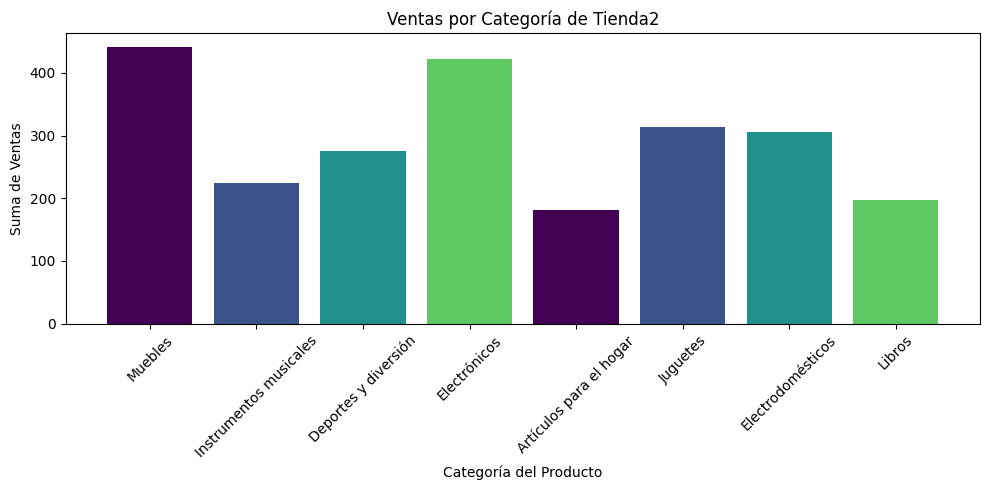

{'Electrodomésticos': 278, 'Muebles': 499, 'Instrumentos musicales': 177, 'Deportes y diversión': 277, 'Electrónicos': 451, 'Juguetes': 315, 'Artículos para el hogar': 177, 'Libros': 185}


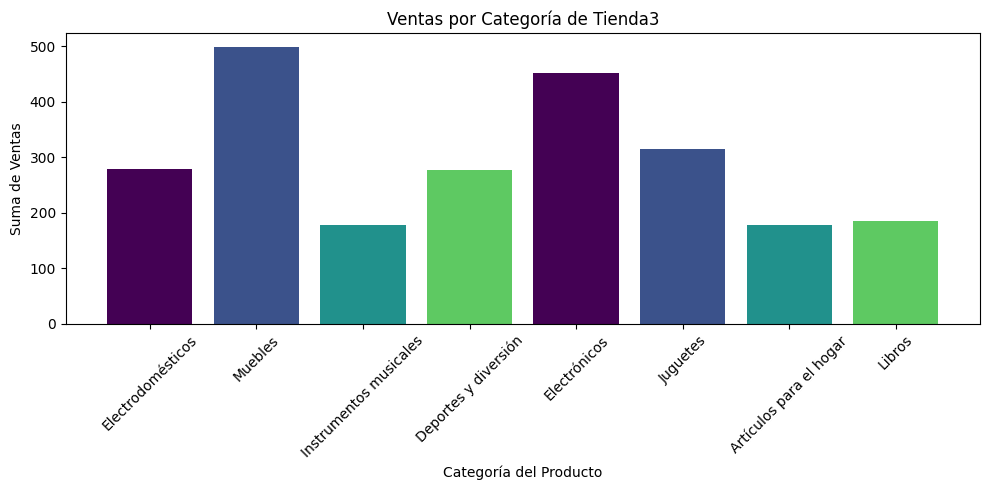

{'Electrodomésticos': 254, 'Muebles': 480, 'Deportes y diversión': 277, 'Libros': 187, 'Electrónicos': 451, 'Instrumentos musicales': 170, 'Juguetes': 338, 'Artículos para el hogar': 201}


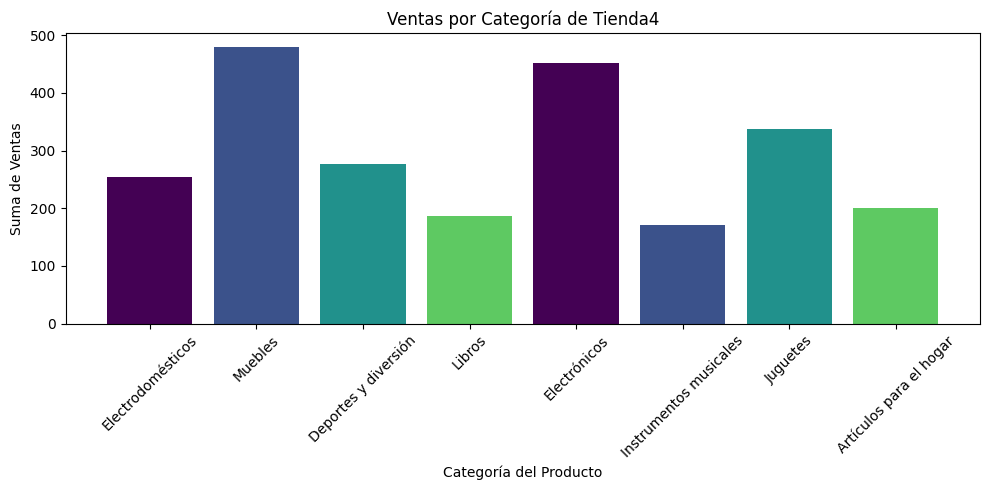

In [ ]:
lista_categorias = [categorias_tiendas(tienda, i) for tienda, i in zip(tiendas, nombres)]

# 3. Calificación promedio de la tienda


In [ ]:
def valoracion_promedio(tienda):
  promedio = round(tienda['Calificación'].sum()/len(tienda),2)
  return promedio

[np.float64(3.98), np.float64(4.04), np.float64(4.05), np.float64(4.0)]


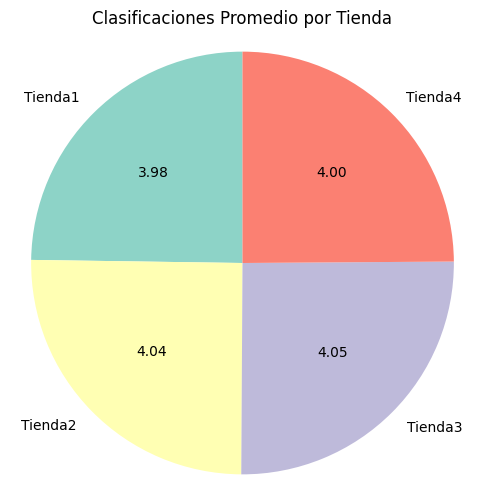

In [ ]:
valores = [valoracion_promedio(tienda) for tienda in tiendas]
print(valores)
def mostrar_valor(pct, valores):
    total = sum(valores)
    valor = pct * total / 100.0
    return f'{valor:.2f}'

plt.figure(figsize=(6, 6))
colores = mpl.colormaps['Set3']
colors = [colores(i) for i in range(len(nombres))]
plt.pie(valores, labels=nombres, autopct=lambda pct: mostrar_valor(pct, valores),
        startangle=90, colors=colors)
plt.title('Clasificaciones Promedio por Tienda')
plt.axis('equal')
plt.show()

# 4. Productos más y menos vendidos

In [ ]:
def mayor_y_menor(tienda):
  productos = {}
  for i in range(len(tienda)):
    producto = tienda.loc[i, "Producto"]

    if producto in productos:
      productos[producto] += 1
    else:
      productos[producto] = 1
  productos_ordenados = dict(sorted(productos.items(), key=lambda item: item[1], reverse=True))
  mas_vendido = next(iter(productos_ordenados.items()))
  menos_vendido = next(reversed(productos_ordenados.items()))
  return mas_vendido, menos_vendido, productos_ordenados

In [ ]:
def mostrar_mas_y_menos_vendido(tienda,nombre):
    mas_vendido, menos_vendido, productos_ordenados = mayor_y_menor(tienda)

    productos = [mas_vendido[0], menos_vendido[0]]
    cantidades = [mas_vendido[1], menos_vendido[1]]

    colores = ['#4CAF50', '#F44336']

    plt.figure(figsize=(8, 4))
    bars = plt.barh(productos, cantidades, color=colores)

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                 f'{int(width)} ventas', va='center')

    plt.xlim(0, max(cantidades) + 10)
    plt.xlabel("Cantidad de Ventas")
    plt.title(f"Producto Menos Vendido vs. Más Vendido en {nombre}")
    plt.tight_layout()
    plt.show()

In [ ]:
def mostrar_productos_ordenados(tienda, nombre):
    _, _, productos_ordenados = mayor_y_menor(tienda)

    productos = list(productos_ordenados.keys())
    cantidades = list(productos_ordenados.values())

    plt.figure(figsize=(10, 6))
    colores = mpl.colormaps['Set3']
    colors = [colores(i) for i in range(len(nombres))]
    bars = plt.barh(productos, cantidades, color=colors)

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.1, bar.get_y() + bar.get_height() / 2,
                 f'{int(width)}', va='center')

    plt.xlabel("Cantidad de Ventas")
    plt.title(f"Productos Ordenados por Ventas en {nombre}")
    plt.tight_layout()
    plt.show()

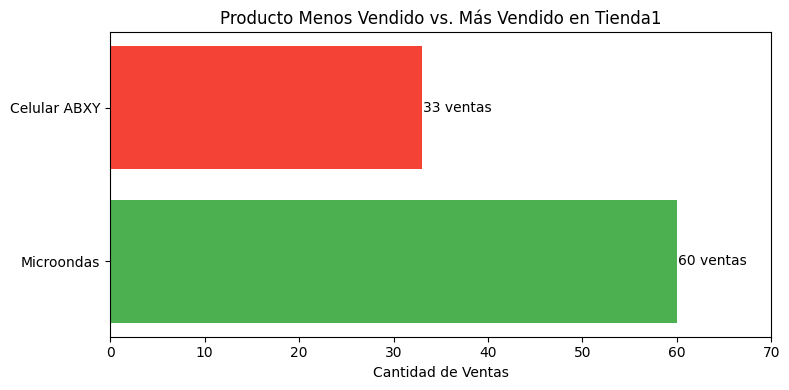

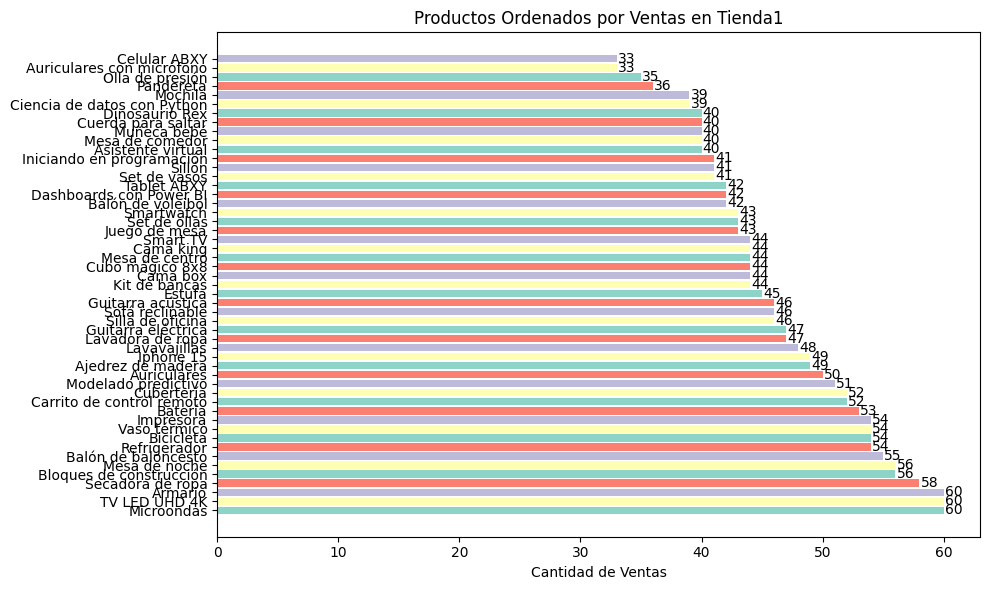

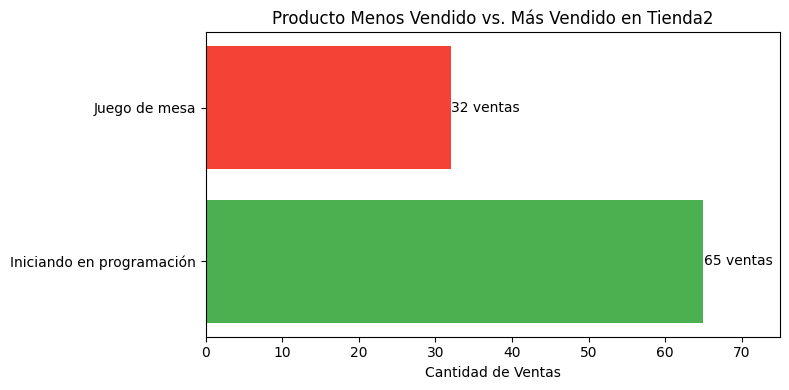

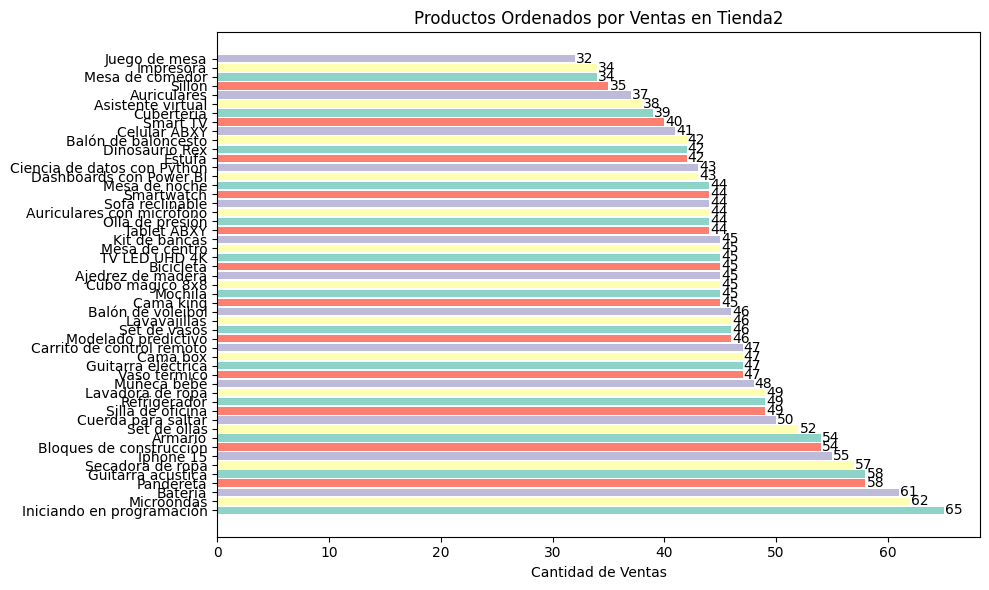

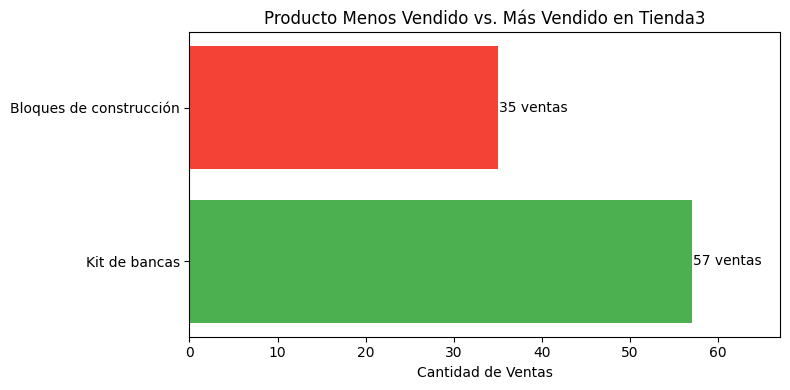

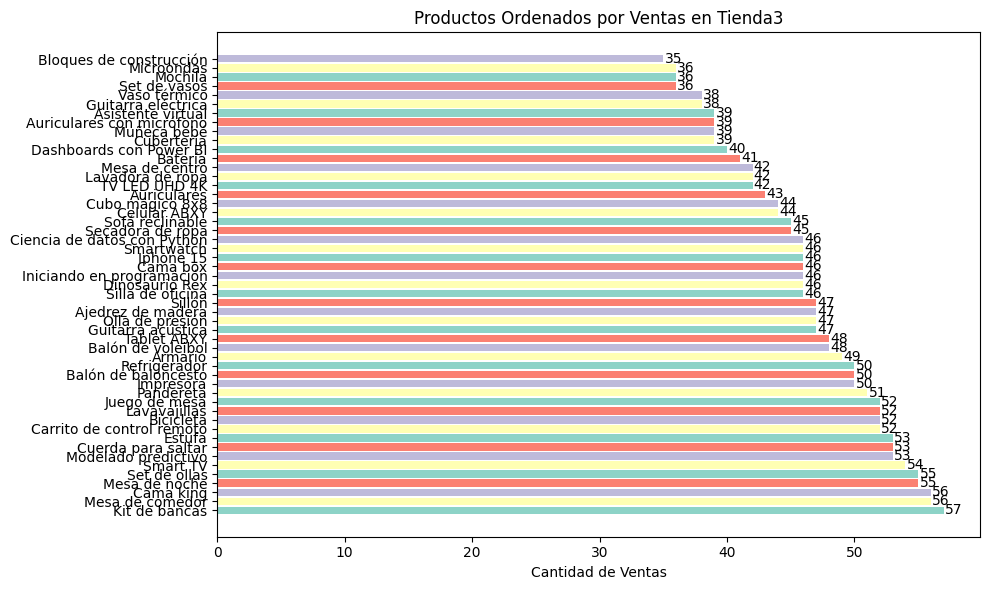

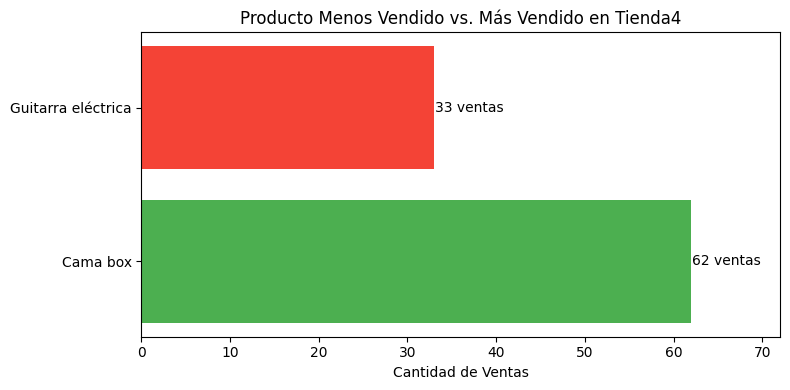

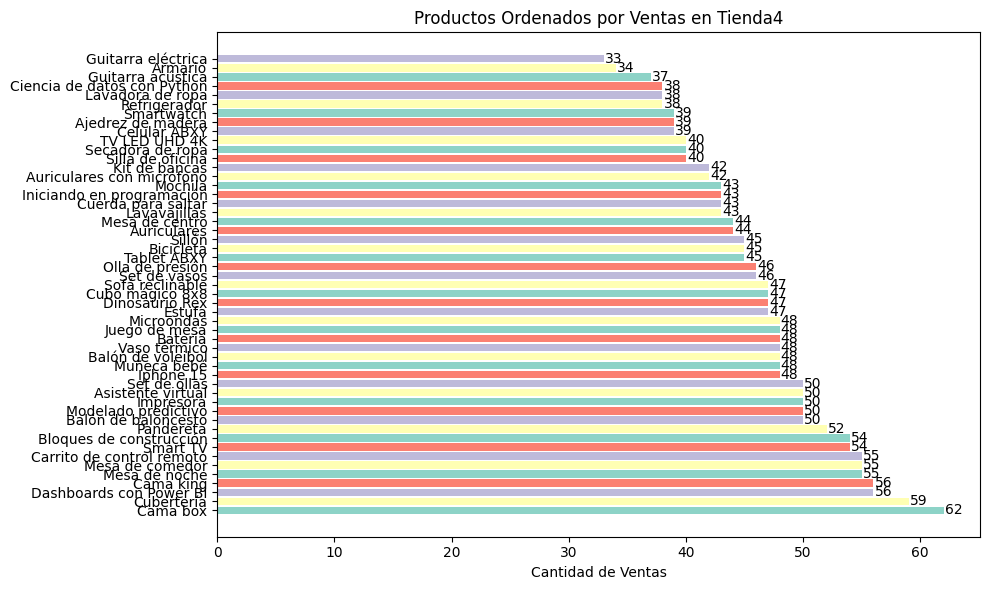

In [ ]:
for tienda, nombre in zip(tiendas,nombres):
  mostrar_mas_y_menos_vendido(tienda,nombre)
  mostrar_productos_ordenados(tienda,nombre)

# 5. Envío promedio por tienda

In [ ]:
def graficos_costo_promedio_envio_por_tienda():
    plt.figure(figsize=(8,5))
    orden_e = envio_prom.sort_values('Envío Prom.', ascending=False)

    n = len(orden_e)
    cmap = mpl.colormaps['Set3']
    colors = cmap(np.linspace(0, 1, n))
    plt.bar(orden_e['Tienda'], orden_e['Envío Prom.'], color=colors)
    plt.title('Costo de envío promedio por tienda')
    plt.xlabel('Tienda'); plt.ylabel('Costo de envío')
    _etiquetar_barras(
        plt.gca(),
        fmt=lambda v: f"{v:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')
    )
    plt.tight_layout()
    plt.show()

In [ ]:
def graficos_Valoracion_promedio_por_Tienda():
    plt.figure(figsize=(3,3))
    colores = mpl.colormaps['Set3']
    orden_v = valoracion.sort_values('Valoración Prom.', ascending=False)
    colors = [colores(i) for i in range(len(orden_v['Valoración Prom.']))]
    plt.pie(orden_v['Valoración Prom.'], labels=orden_v['Tienda'], autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title('Valoración promedio por tienda')
    plt.axis('equal')
    plt.tight_layout(); plt.show()

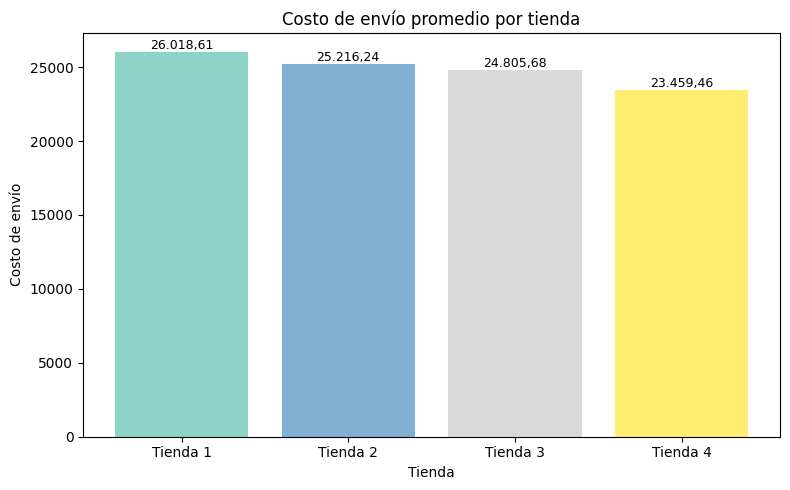

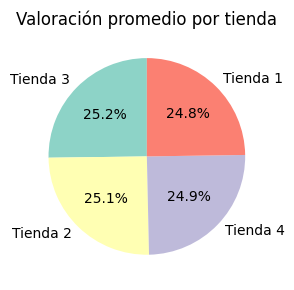

In [ ]:
graficos_costo_promedio_envio_por_tienda()
graficos_Valoracion_promedio_por_Tienda()

## 6. Análisis del desempeño geográfico (EXTRA)


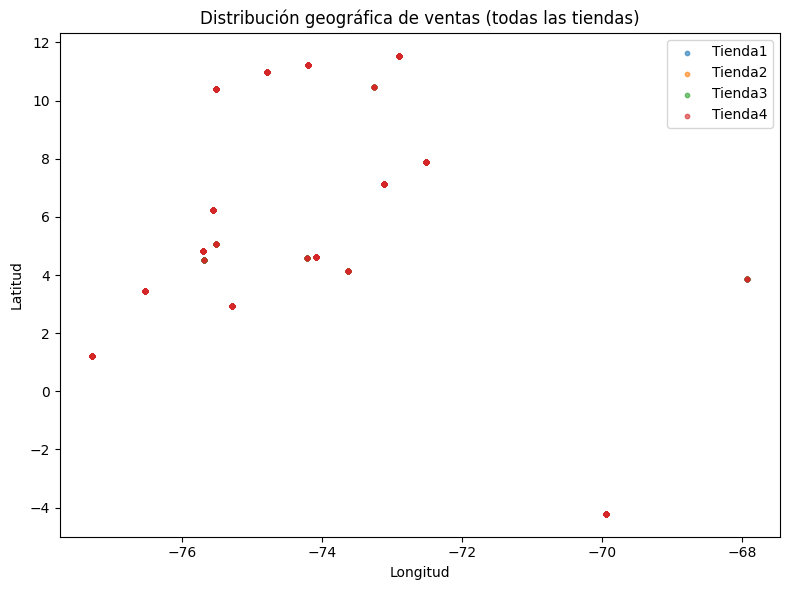

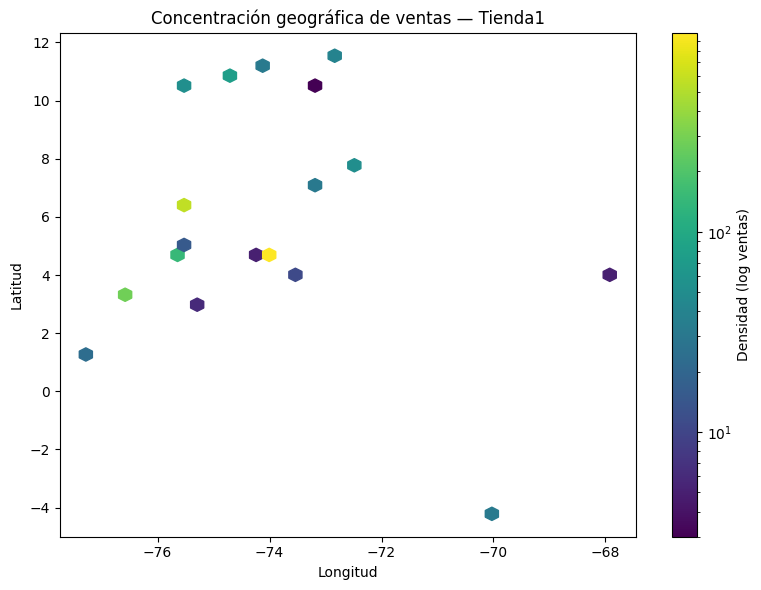

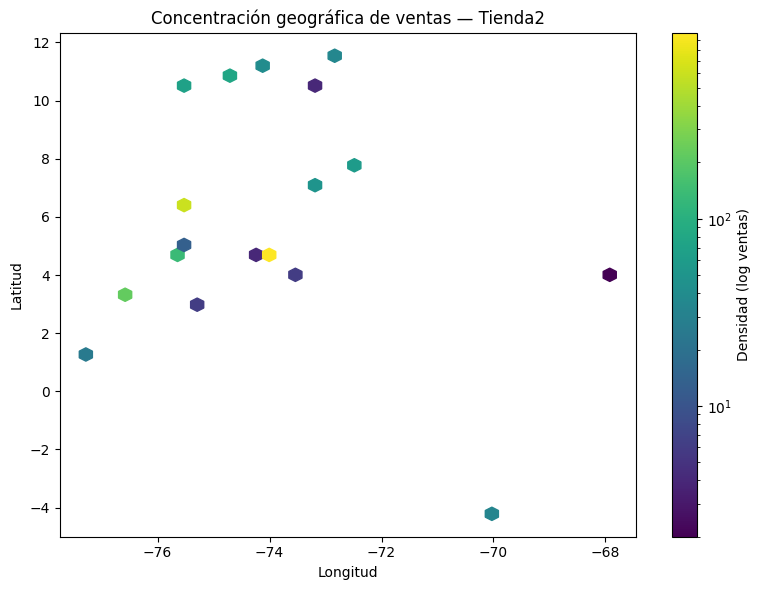

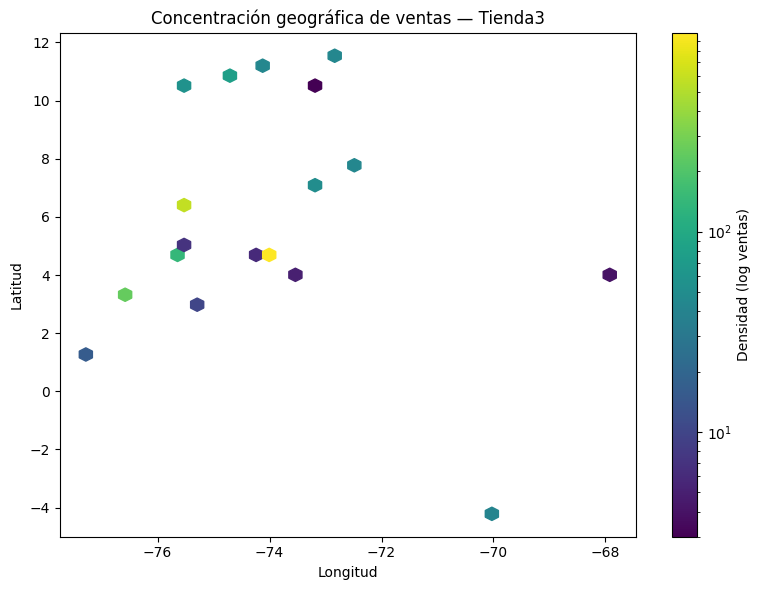

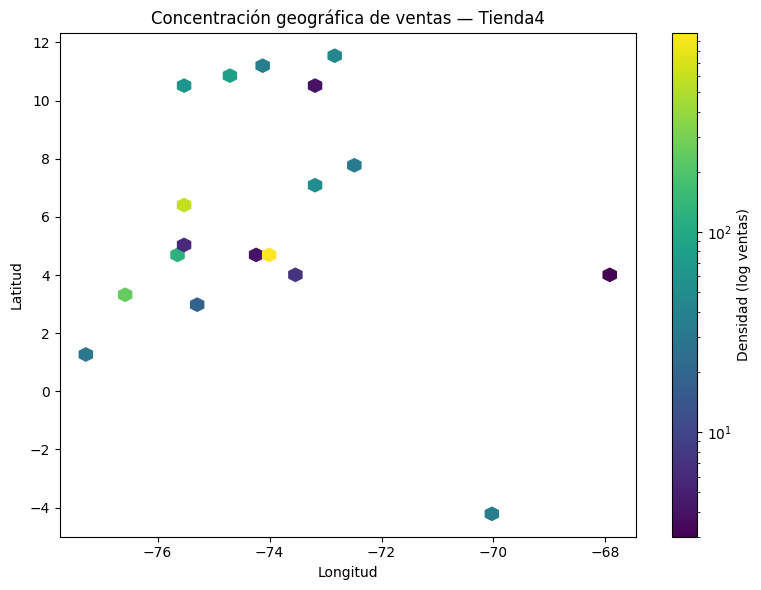

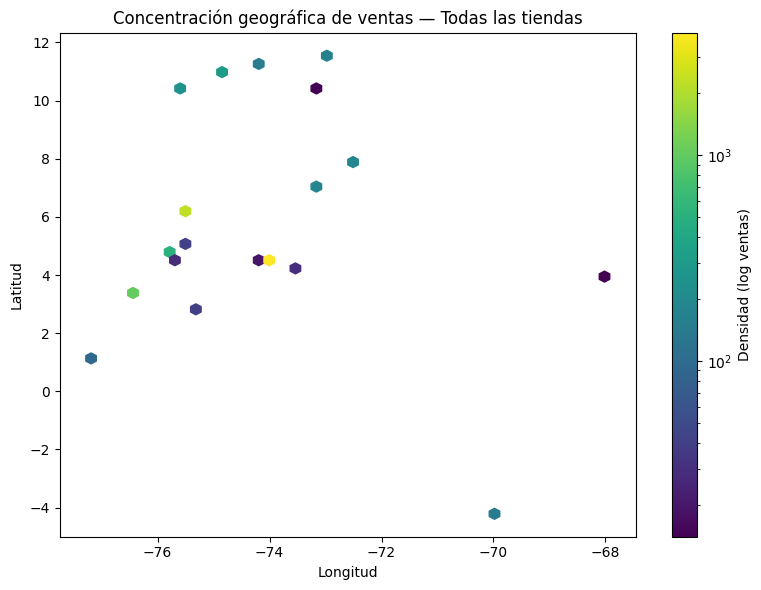


Top 5 regiones por ingresos — Tienda1 (lat_bin, lon_bin):


,lat_bin,lon_bin,Ingresos,Ventas,ValoraciónProm
8,4.6,-74.1,440005000.0,984,4.089431
11,6.3,-75.6,296858100.0,563,3.866785
3,3.4,-76.5,154493700.0,283,3.985866
9,4.8,-75.7,56214300.0,133,3.947368
13,7.9,-72.5,37879500.0,51,3.882353



Top 5 regiones por ingresos — Tienda2 (lat_bin, lon_bin):


,lat_bin,lon_bin,Ingresos,Ventas,ValoraciónProm
27,4.6,-74.1,479959200.0,985,4.136041
30,6.3,-75.6,297246700.0,594,3.919192
22,3.4,-76.5,118257600.0,222,4.252252
28,4.8,-75.7,43073800.0,128,3.953125
32,7.9,-72.5,28991500.0,59,3.983051



Top 5 regiones por ingresos — Tienda3 (lat_bin, lon_bin):


,lat_bin,lon_bin,Ingresos,Ventas,ValoraciónProm
46,4.6,-74.1,475562100.0,983,4.160732
49,6.3,-75.6,250580600.0,580,4.001724
41,3.4,-76.5,109287600.0,248,4.056452
47,4.8,-75.7,62504500.0,134,4.044776
54,11.0,-74.8,36768500.0,77,4.025974



Top 5 regiones por ingresos — Tienda4 (lat_bin, lon_bin):


,lat_bin,lon_bin,Ingresos,Ventas,ValoraciónProm
65,4.6,-74.1,419332000.0,991,4.068618
68,6.3,-75.6,251983800.0,577,3.916811
60,3.4,-76.5,124487200.0,254,3.925197
66,4.8,-75.7,64134700.0,122,4.114754
73,11.0,-74.8,34623000.0,80,3.887500



Regiones con mayor participación de ingresos — Tienda1


,lat_bin,lon_bin,Ingresos,ShareRegion,ValoraciónProm
8,4.6,-74.1,440005000.0,0.382320,4.089431
11,6.3,-75.6,296858100.0,0.257940,3.866785
3,3.4,-76.5,154493700.0,0.134240,3.985866
9,4.8,-75.7,56214300.0,0.048845,3.947368
13,7.9,-72.5,37879500.0,0.032913,3.882353



Regiones con mayor participación de ingresos — Tienda2


,lat_bin,lon_bin,Ingresos,ShareRegion,ValoraciónProm
27,4.6,-74.1,479959200.0,0.429939,4.136041
30,6.3,-75.6,297246700.0,0.266268,3.919192
22,3.4,-76.5,118257600.0,0.105933,4.252252
28,4.8,-75.7,43073800.0,0.038585,3.953125
32,7.9,-72.5,28991500.0,0.025970,3.983051



Regiones con mayor participación de ingresos — Tienda3


,lat_bin,lon_bin,Ingresos,ShareRegion,ValoraciónProm
46,4.6,-74.1,475562100.0,0.433109,4.160732
49,6.3,-75.6,250580600.0,0.228211,4.001724
41,3.4,-76.5,109287600.0,0.099532,4.056452
47,4.8,-75.7,62504500.0,0.056925,4.044776
54,11.0,-74.8,36768500.0,0.033486,4.025974



Regiones con mayor participación de ingresos — Tienda4


,lat_bin,lon_bin,Ingresos,ShareRegion,ValoraciónProm
65,4.6,-74.1,419332000.0,0.403835,4.068618
68,6.3,-75.6,251983800.0,0.242671,3.916811
60,3.4,-76.5,124487200.0,0.119886,3.925197
66,4.8,-75.7,64134700.0,0.061764,4.114754
73,11.0,-74.8,34623000.0,0.033343,3.887500


In [ ]:
# ============================================================
# EXTRA (OPCIONAL): Análisis geográfico de ventas por tienda
# ============================================================

# --- 0) Helpers: toma DataFrames de tiendas y localiza columnas lat/lon ---
def _get_tiendas_or_lists():
    if 'tiendas' in globals() and 'nombres' in globals() and len(tiendas) == len(nombres) and len(tiendas) > 0:
        return tiendas, nombres
    pares = [('tienda','Tienda 1'), ('tienda2','Tienda 2'), ('tienda3','Tienda 3'), ('tienda4','Tienda 4')]
    tdfs, nms = [], []
    for var, nm in pares:
        df = globals().get(var)
        if isinstance(df, pd.DataFrame):
            tdfs.append(df); nms.append(nm)
    if not tdfs:
        raise ValueError("No encontré DataFrames de tiendas. Ejecuta antes la celda que los carga.")
    return tdfs, nms

# Si ya tienes _col definido antes, lo reutiliza; si no, lo define aquí.
if '_col' not in globals():
    def _col(df, preferido, aliases=()):
        cols = {c.lower(): c for c in df.columns}
        for c in [preferido] + list(aliases):
            if c and c.lower() in cols:
                return cols[c.lower()]
        for c_low, c_orig in cols.items():
            for c in [preferido] + list(aliases):
                if c and c.lower() in c_low:
                    return c_orig
        return None

# --- 1) Normaliza mínimamente para incluir Lat/Lon + métricas básicas ---
def normalizar_geo(df, nombre_tienda):
    precio = _col(df, 'Precio', ('price','valor','unit_price'))
    calif  = _col(df, 'Calificación', ('review','rating','review_score','evaluación','evaluacion'))
    fecha  = _col(df, 'Fecha', ('order_purchase_timestamp','date','fecha_compra'))
    cat    = _col(df, 'Categoría del Producto', ('categoria','category','product_category'))
    prod   = _col(df, 'Producto', ('product','nombre_producto'))

    latc   = _col(df, 'lat', ('latitude','latitud'))
    lonc   = _col(df, 'lon', ('lng','longitude','longitud','lon'))

    out = pd.DataFrame({
        'Tienda': nombre_tienda,
        'Precio': pd.to_numeric(df[precio], errors='coerce') if precio else np.nan,
        'Calificación': pd.to_numeric(df[calif], errors='coerce') if calif else np.nan,
        'Fecha': pd.to_datetime(df[fecha], errors='coerce', dayfirst=True) if fecha else pd.NaT,
        'Categoría': df[cat] if cat else np.nan,
        'Producto': df[prod] if prod else np.nan,
        'Latitud': pd.to_numeric(df[latc], errors='coerce') if latc else np.nan,
        'Longitud': pd.to_numeric(df[lonc], errors='coerce') if lonc else np.nan,
    })
    # Filtros de plausibilidad geográfica
    out = out[(out['Latitud'].between(-90, 90)) & (out['Longitud'].between(-180, 180))]
    return out.dropna(subset=['Latitud','Longitud','Precio'])

tiendas_geo, nombres_geo = _get_tiendas_or_lists()
geo_norm = [normalizar_geo(df, nm) for df, nm in zip(tiendas_geo, nombres_geo)]
geo_df = pd.concat(geo_norm, ignore_index=True)

if geo_df.empty:
    print("No se encontraron coordenadas válidas (Lat/Lon). Revisa los nombres de columnas en los CSV.")
else:
    # --- 2) Dispersión: puntos de venta por tienda (todas juntas) ---
    plt.figure(figsize=(8,6))
    for tienda_nombre in geo_df['Tienda'].unique():
        sub = geo_df[geo_df['Tienda'] == tienda_nombre]
        # Un scatter por tienda (Matplotlib usa el color cycle por defecto; no fijamos colores)
        plt.scatter(sub['Longitud'], sub['Latitud'], s=10, alpha=0.6, label=tienda_nombre)
    plt.title('Distribución geográfica de ventas (todas las tiendas)')
    plt.xlabel('Longitud'); plt.ylabel('Latitud')
    plt.legend()
    plt.tight_layout(); plt.show()

    # --- 3) Heatmap (hexbin) por tienda: concentración de ventas ---
    for tienda_nombre in geo_df['Tienda'].unique():
        sub = geo_df[geo_df['Tienda'] == tienda_nombre]
        if len(sub) == 0:
            continue
        plt.figure(figsize=(8,6))
        # bins='log' ayuda a ver mejor zonas densas y poco densas
        hb = plt.hexbin(sub['Longitud'], sub['Latitud'], gridsize=40, bins='log')  # sin cmap explícito
        plt.colorbar(hb, label='Densidad (log ventas)')
        plt.title(f'Concentración geográfica de ventas — {tienda_nombre}')
        plt.xlabel('Longitud'); plt.ylabel('Latitud')
        plt.tight_layout(); plt.show()

    # --- 4) Heatmap combinado: todas las tiendas ---
    plt.figure(figsize=(8,6))
    hb_all = plt.hexbin(geo_df['Longitud'], geo_df['Latitud'], gridsize=50, bins='log')
    plt.colorbar(hb_all, label='Densidad (log ventas)')
    plt.title('Concentración geográfica de ventas — Todas las tiendas')
    plt.xlabel('Longitud'); plt.ylabel('Latitud')
    plt.tight_layout(); plt.show()

    # --- 5) Regiones (grid) y desempeño por tienda ---
    # Celda ~0.1° aprox. (~11 km); ajusta a 0.2 ó 0.5 si la muestra es grande.
    geo_df['lat_bin'] = geo_df['Latitud'].round(1)
    geo_df['lon_bin'] = geo_df['Longitud'].round(1)

    grid_perf = (geo_df
                 .groupby(['Tienda','lat_bin','lon_bin'], as_index=False)
                 .agg(Ingresos=('Precio','sum'),
                      Ventas=('Precio','size'),
                      ValoraciónProm=('Calificación','mean')))

    # Top 5 regiones por ingresos, por tienda (tabla)
    for t in geo_df['Tienda'].unique():
        sub = grid_perf[grid_perf['Tienda'] == t].sort_values('Ingresos', ascending=False).head(5)
        print(f'\nTop 5 regiones por ingresos — {t} (lat_bin, lon_bin):')
        display(sub[['lat_bin','lon_bin','Ingresos','Ventas','ValoraciónProm']])

    # --- 6) ¿Rinde mejor o peor que el promedio en ciertas regiones?
    # Participación de ingresos por región (por tienda) vs total de esa tienda
    totales = grid_perf.groupby('Tienda', as_index=False)['Ingresos'].sum().rename(columns={'Ingresos':'IngresosTot'})
    grid_share = grid_perf.merge(totales, on='Tienda')
    grid_share['ShareRegion'] = grid_share['Ingresos'] / grid_share['IngresosTot']

    # Muestra las 5 regiones más "dominantes" por tienda (mayor share)
    for t in geo_df['Tienda'].unique():
        sub = grid_share[grid_share['Tienda'] == t].sort_values('ShareRegion', ascending=False).head(5)
        print(f'\nRegiones con mayor participación de ingresos — {t}')
        display(sub[['lat_bin','lon_bin','Ingresos','ShareRegion','ValoraciónProm']])

    # --- 7) (Opcional) Mapa interactivo con Folium (requieres instalar folium):
    # from google.colab import output
    # !pip -q install folium
    # import folium
    # center = [geo_df['Latitud'].mean(), geo_df['Longitud'].mean()]
    # m = folium.Map(location=center, zoom_start=5)
    # for _, r in geo_df.iterrows():
    #     folium.CircleMarker([r['Latitud'], r['Longitud']],
    #                         radius=2, fill=True,
    #                         tooltip=f"{r['Tienda']} | ${r['Precio']:.2f} | Cal: {r['Calificación']:.1f}").add_to(m)
    # m


## Desarrollo del Análisis

### 1. Ingresos Totales

Se calculó el ingreso total de cada tienda mediante la suma de los precios de los productos vendidos:

Tienda 1: $1.150.880.400

Tienda 2: $1.116.343.500

Tienda 3: $1.098.019.600

Tienda 4: $1.038.375.700

**Observacion:** Tienda 1 lidera en ingresos en comparacion con las otras tiendas. Sin embargo, el ingreso por sí solo no garantiza sostenibilidad si no se acompaña de buena atención y logística.

### 2. Categorías de Productos Más y Menos Vendidas

Se revisaron las cantidades de productos vendidos por categoría en cada tienda. A continuación, el resumen:

* Tienda 1

* Muebles: 465

* Electrónicos: 448

* Juguetes: 324

* Deportes y diversión: 284

* Electrodomésticos: 312

* Instrumentos musicales: 182

* Libros: 173

* Artículos para el hogar: 171

Tienda 2

* Muebles: 442

* Electrónicos: 422

* Juguetes: 313

* Deportes y diversión: 275

* Electrodomésticos: 305

* Instrumentos musicales: 224

* Libros: 197

* Artículos para el hogar: 181

Tienda 3

* Muebles: 499

* Electrónicos: 451

* Juguetes: 315

* Deportes y diversión: 277

* Electrodomésticos: 278

* Instrumentos musicales: 177

* Libros: 185

* Artículos para el hogar: 177

Tienda 4

* Muebles: 480

* Electrónicos: 451

* Juguetes: 338

* Deportes y diversión: 277

* Electrodomésticos: 254

* Instrumentos musicales: 170

* Libros: 187

* Artículos para el hogar: 201

Todas las tiendas venden principalmente Muebles y Electrónicos, pero Tienda 2 muestra una distribución más uniforme y equilibrada. Tiene buen rendimiento también en categorías como Instrumentos musicales y Libros. En contraste, Tienda 4, aunque tiene buenos números en Muebles y Juguetes, presenta menor rendimiento en otras categorías clave.

### 3. Calificaciones Promedio de los Clientes

El nivel de satisfacción del cliente fue analizado a partir de la calificación promedio:

Tienda 1: 3.98

Tienda 2: 4.04

Tienda 3: 4.05

Tienda 4: 4.0

Como se puede apreiar, si bien la tienda 1 fue la que mayores ingresos genero, fue la que obtuvo la menor clasificacion en las valoraciones de los clientes, seguida de la tienda 4, que fue la que genero menos ingresos.

En base a lo que tenemos por el momento, la tienda a eliminar estaria entre la Tienda 1 y Tienda 4

### 4. Productos Más y Menos Vendidos

#### Tienda 1
* Celular ABXY = 33
* Microondas = 60

#### Tienda 2
* Juegos de Mesa = 32
* Iniciando En Programacion = 65

#### Tienda 3
* Bloques de Construccion = 35
* Kit de Bancas = 57

#### Tienda 4
* Guitarra Electrica = 33
* Cama Box = 62

De estos datos no se puede obtener informacion significativa para dedicir o ir descartando que tienda debe ser o no eliminada.

### 5. Coste Promedio de Envío

Este es un factor importante para la rentabilidad y satisfacción del cliente:

Tienda 1: $26019

Tienda 2: $25216

Tienda 3: $24806

Tienda 4: $23459

Aunque Tienda 4 tiene el coste de envío más bajo, también es la segunda con menor calificación y la primera con ingresos más bajos. Mientras que tienda 1 es la que genera mas ingresos, pero la que tambien tiene un costo promedio de envio mas alto.

### Diferencia % entre Tiendas 1 y 4

$\text{Diferencia %}=\left(\frac{26019-23459}{26019}\right)\times 100 \approx \left(\frac{2560}{26019}\right)\times 100 \approx 9.83\%$

La Tienda 4 tiene un valor promedio de envío aproximadamente 9.83% menor que la Tienda 1.

$\text{Diferencia %}=\left(\frac{1,150,880,400-1,038,375,700}{1,150,880,400}\right)\times 100 \approx \left(\frac{112,504,700}{1,150,880,400}\right)\times 100 \approx 9.78\%$


La Tienda 4 generó aproximadamente 9.78% menos ingresos que la Tienda 1.

## Resumen de Métricas por Tienda

In [ ]:
metrics = ingresos.merge(valoracion, on='Tienda').merge(envio_prom, on='Tienda')

n = len(metrics)
metrics['P_ingresos'] = (n + 1 - metrics['Ingresos'].rank(ascending=True,  method='dense'))
metrics['P_review']   = (n + 1 - metrics['Valoración Prom.'].rank(ascending=True, method='dense'))
metrics['P_envio']    = (n + 1 - metrics['Envío Prom.'].rank(ascending=False, method='dense'))
metrics['Bad_Score']  = metrics[['P_ingresos','P_review','P_envio']].sum(axis=1)

metrics_orden = metrics.sort_values('Bad_Score', ascending=False)
print('\n=== Resumen de métricas por tienda (ranking de peor desempeño) ===')
display(metrics_orden[['Tienda','Ingresos','Valoración Prom.','Envío Prom.',
                       'P_ingresos','P_review','P_envio','Bad_Score']])

candidata = metrics_orden.iloc[1]['Tienda']
display(Markdown(
    f"""
**Tienda sugerida para vender:** **{candidata}**

**Fundamento (Bad_Score)**
- Ingresos: {metrics_orden.iloc[1]['Ingresos']:.2f}
- Valoración Prom.: {metrics_orden.iloc[1]['Valoración Prom.']:.2f}
- Envío Prom.: {metrics_orden.iloc[1]['Envío Prom.']:.2f}

> El menor en **ingresos**, **segunda peor valoración** y **costo de envío moderado** suman más puntos de peor desempeño.
"""
))



=== Resumen de métricas por tienda (ranking de peor desempeño) ===


,Tienda,Ingresos,Valoración Prom.,Envío Prom.,P_ingresos,P_review,P_envio,Bad_Score
0,Tienda 1,1.150880e+09,3.976685,26018.609580,1.0,4.0,4.0,9.0
3,Tienda 4,1.038376e+09,3.995759,23459.457167,4.0,3.0,1.0,8.0
1,Tienda 2,1.116344e+09,4.037304,25216.235693,2.0,2.0,3.0,7.0
2,Tienda 3,1.098020e+09,4.048326,24805.680373,3.0,1.0,2.0,6.0



**Tienda sugerida para vender:** **Tienda 4**  

**Fundamento (Bad_Score)**  
- Ingresos: 1038375700.00  
- Valoración Prom.: 4.00  
- Envío Prom.: 23459.46  

> El menor en **ingresos**, **segunda peor valoración** y **costo de envío moderado** suman más puntos de peor desempeño.


#### conclusión

* **Tienda 1:** Aunque tiene los ingresos más altos, sus calificaciones son las peores y su coste de envío es el más elevado. Esto indica posibles problemas logísticos o de servicio al cliente que podrían afectar la sostenibilidad a largo plazo.

* **Tienda 2:** Presenta buena distribución de ventas por categorías, buenas calificaciones y un coste de envío aceptable. No es líder en nada, pero es sólida y equilibrada en todo.

* **Tienda 3:** Tiene la mejor calificación, ingresos aceptables, y coste de envío moderado.

* **Tienda 4:** Tiene los peores ingresos, segunda peor calificación y aunque el coste de envío es el mejor, su desempeño general es más débil, especialmente en ventas por categoría.


## Recomendacion

Lo mejor para Sr Juan seria eliminar la Tienda 4, ya que es la menos rentable en general. Su único punto fuerte es el bajo coste de envío, pero no compensa sus bajos ingresos, calificación mediocre y pobre desempeño en categorías clave. Además, vender Tienda 4 permitirá concentrar sus esfuerzos en las tiendas con mejor desempeño, como Tienda 1, Tienda 2 o Tienda 3, que mantienen una buena relación entre ingresos, satisfacción del cliente y eficiencia logística. Además, la venta de Tienda 4 puede representar una oportunidad para reinvertir en mejoras tecnológicas, inventario o expansiones de mercado en sus tiendas más rentables.